In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.ner_metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 с учётом регистра
    2. Version 1 --- обученаая на нетронутом тренировочном наборе данных i2b2 2006 без учёта регистра
    3. Version 2 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 с учётом регистра
    4. Version 3 --- обученаая на нетронутом тренировочном наборе данных i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на анонимизированном с помощью справочников наборе данных i2b2 2014 без учёта регистра
    6. Version 5 --- обученная на анонимизированном с помощью GPT2 валидационном наборе данных i2b2 2014 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    7. Version 6 --- обученная на анонимизированном с помощью GPT2 тренировочном наборе данных i2b2 2006 без учёта регистра, GPT2 обучено на тренировочном наборе данных i2b2 2014 
    8. Version 7 --- обученаая на нетронутом валидационном наборе данных i2b2 2014 без учёта регистра

### Этап 1: Демонстрация качества искусственных примеров личных сущностей
Правдоподобность искусственных примеров будет оцениваться по метрикам их определения лучшей NER моделью --- BERT-large-uncased, дообученной на i2b2 2014

In [7]:
# Инициализация алгоритма генерации искусственных сущностей на основе справочника
anonymization = ReferenceBookAnonymization(**anon_config, other_label=i2b2_2014_data_config['other_label'])

In [8]:
# Инициализация обезличенного тестового датасета
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               anonymization=anonymization, **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn(),
                             num_workers=10,
                             pin_memory=False,
                             persistent_workers=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Инициализация модели
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
ner_model = PretrainedBertNER.load_from_checkpoint(t_reader.get_ckpt_path(3))

In [10]:
# Тестирование
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9961634874343872
     test_precision         0.9961634874343872
       test_recall          0.9575614929199219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9575614929199219,
  'test_precision': 0.9961634874343872,
  'test_f1': 0.9961634874343872}]

              precision    recall  f1-score   support

        NAME     0.9706    0.9904    0.9804      9067
  PROFESSION     0.9218    0.9324    0.9270       695
    LOCATION     0.9446    0.9071    0.9255     10242
         AGE     0.9815    0.9865    0.9840      1184
        DATE     0.9949    0.9637    0.9790     35814
          ID     0.8927    0.9396    0.9155      4337
     CONTACT     0.9510    0.9822    0.9664      2471

   micro avg     0.9731    0.9576    0.9653     63810
   macro avg     0.9510    0.9574    0.9540     63810
weighted avg     0.9737    0.9576    0.9653     63810



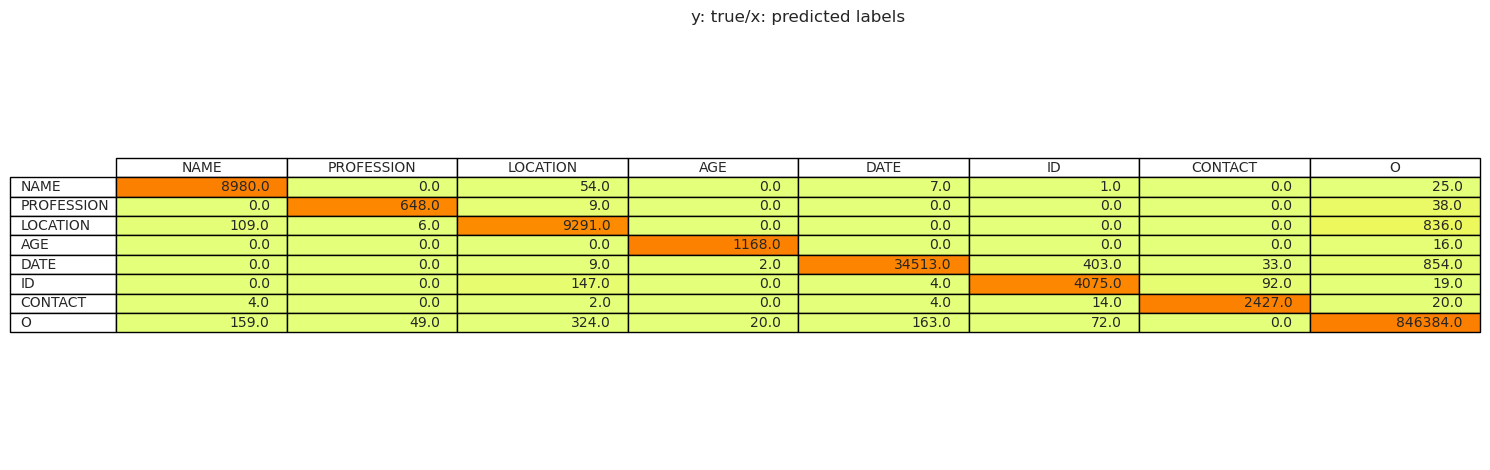

Wrongly predicted examples:
_____ Record 218-05:-1 _____
| Sentence:    | with | an | elevated | lactate | , | he | may | be | septic | . | thank | you | for | allowing | us | to | participate | in | this | patient | ' | s | care | . | please | page | with | any | additional | questions | . | attending | to | staff | . | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | ruben | carla | , | md | gi | fellow | ascension | columbia | st       | mary     | '        | s        | hospital | ozaukee  | gastroenterology | pager | (       | 497     | )       | 549     | -       |
| True labels: | O    | O  | O        | O       | O | O  | O   | O  | O      | O | O     | O   | O   | O        | O  | O  | O           | O  | O    | O       | O | O | O    | O | O      | O    | O    | O   | O          | O         | O | O         | O  | O     | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O 

In [11]:
# Метрики
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

In [12]:
faults = stats.get_specific_failed_predictions('LOCATION')

Wrongly predicted examples:
_____ Record 262-02:-20 _____
| Sentence:    | record | date | : | 23   | /    | 10   | /    | 1927 | name | : | rafael | lois | mrn | : | 6701039453 | initial | visit | this | is | a | 52  | - | year | - | old | white | female | coming | for | her | fu | visit | . | the | patient | has | a | history | of | type | ii | diabetes | mellitus | and | pituitary | adenoma | and | recently | was | hospitalized | at | missouri | delta    | medical  | center   | with | general | malaise | syndrome | and | back | / | chest | pain | . | initially | the | patient | was | seen | at | titus    | county   | hospital | district | dba      | titus    | regional | medical  | center   | and | cardiac | ischemia | was | ruled | out |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O    | O | NAME   | NAME | O   | O | ID         | O       | O     | O    | O  | O | AGE | O | O    | O | O   | O     | O      | O      | O   | O   | O  | O     | O | O   | O   

**Вывод:**  
В целом все метки предсказываются с точностью, близко к аналогичной у первоначальных сущностей. Самое низкое качество распознавания у модели оказалось для класса 'LOCATION', предположительно, из-за слишком длинных названий больниц в используемом справочнике. Однако в первых версиях генератора синтетических данных присутствовали проблемы с меткой 'CONTACT'. Основная трудность для модели заключалась в предсказании номеров телефонов, если их генерация использовала российский стиль их написания. Тогда модель определяла его, как уникальный идентификатор. Проблема была решена сменной формата номера.  
  
Как видно, в оригинальных данных не используется код страны, и цифры сгруппированы отлично от распространённого российского варианта.  
Запись **347-03**  
Original:  (121) 537-3484  
Russian format: +1 933 257-12-32  
Запись **314-02**  
Original:  (676) 312-7662  
Russian format: +1 995 672-52-24  
  
Ещё один вариант записи номера телефона в оригинальных данных: "665-578-7821"

### Этап 2: Обучение модели на анонимизированных данных

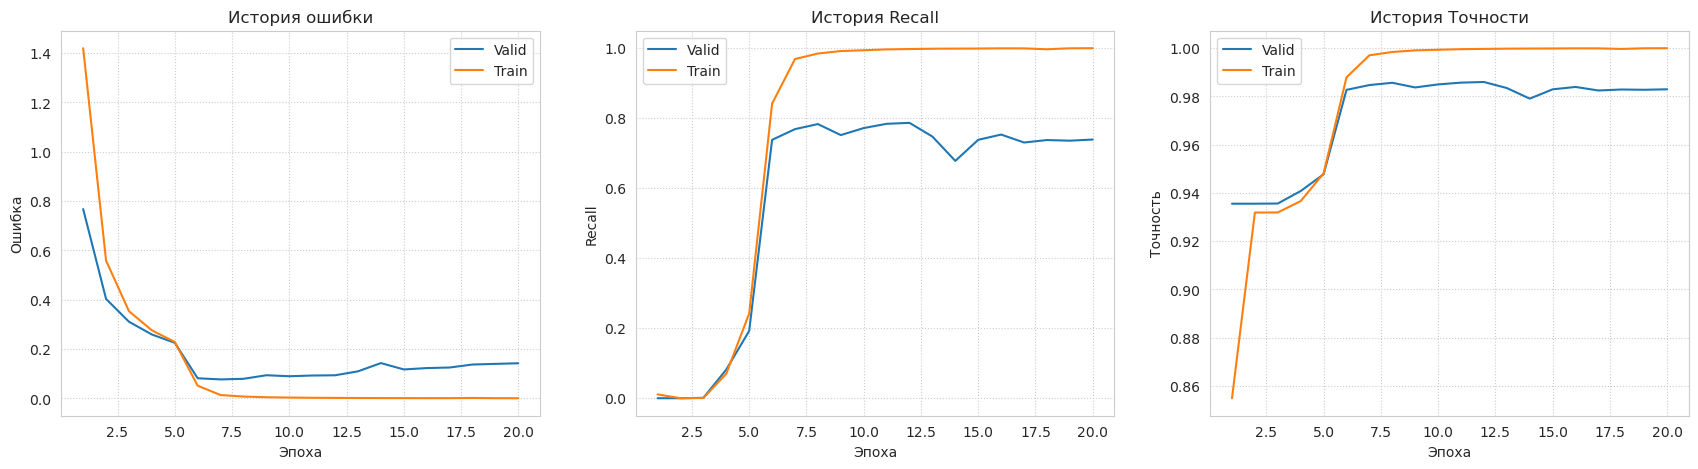

In [14]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_ner_tensorboard_graphics(4)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [15]:
# Data processing
test_dataset = get_ner_dataset(path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               **i2b2_2014_data_config)
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 512). Running this sequence through the model will result in indexing errors


In [16]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(4)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [17]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:478: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9859472513198853
     test_precision         0.9859472513198853
       test_recall           0.786352276802063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.786352276802063,
  'test_precision': 0.9859472513198853,
  'test_f1': 0.9859472513198853}]

              precision    recall  f1-score   support

        NAME     0.9931    0.6152    0.7598     11741
  PROFESSION     0.8889    0.9146    0.9016       656
    LOCATION     0.8477    0.7136    0.7749      6211
         AGE     0.9535    0.8985    0.9251      1300
        DATE     0.9904    0.8808    0.9324     32754
          ID     0.8914    0.5953    0.7139      4510
     CONTACT     0.5160    0.7866    0.6232      1270

   micro avg     0.9480    0.7864    0.8596     58442
   macro avg     0.8687    0.7721    0.8044     58442
weighted avg     0.9559    0.7864    0.8569     58442



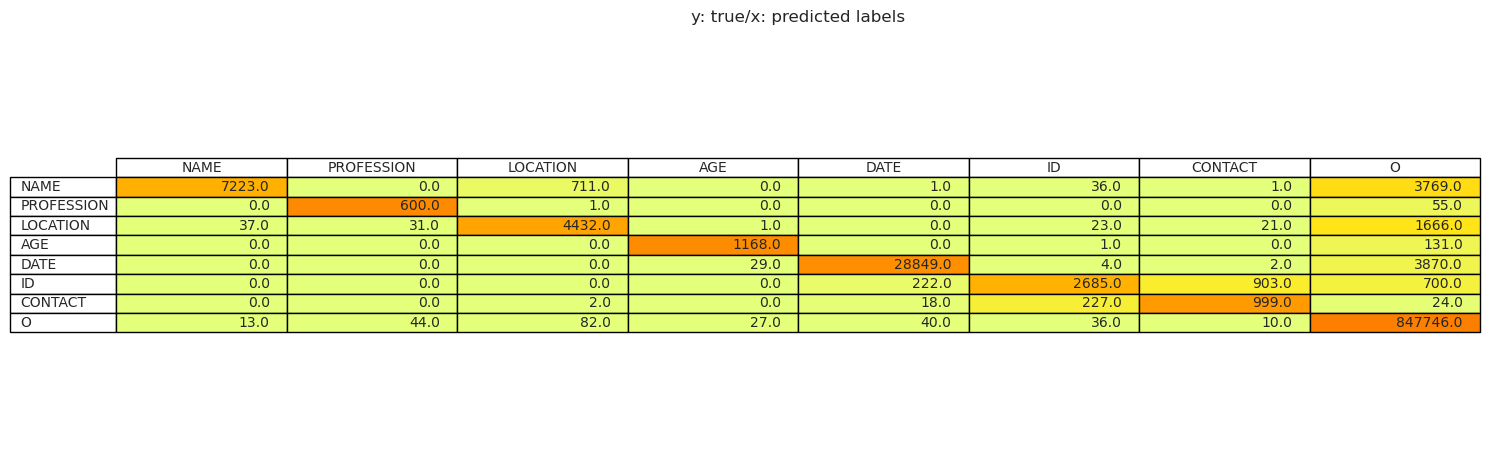

Wrongly predicted examples:
_____ Record 376-01:-13 _____
| Sentence:    | l4 | / | 5 | . | he | will | be | seeing | dr | . | sheehan | . | mr | . | whitehead | is | contemplating | surgery | as | he | cannot | walk | without | pain | . | elevated | blood | sugar | bs | was | 191 | in | 11   | /    | 1    | /    | 69   | and | was | in | similar | range | during | his | hospitalization | in | montreal | medical  | . | he | has | been | on | meds | for | niddm | . | he | could | not | tolerate | high | dose | of | glucophage | and | is | now | seeing | endocrine | . | his | hba1c | was | 7 | . | 5 | in | 6    | /    | 71   | on |
| True labels: | O  | O | O | O | O  | O    | O  | O      | O  | O | NAME    | O | O  | O | NAME      | O  | O             | O       | O  | O  | O      | O    | O       | O    | O | O        | O     | O     | O  | O   | O   | O  | DATE | DATE | DATE | DATE | DATE | O   | O   | O  | O       | O     | O      | O   | O               | O  | LOCATION | LOCATION | O

In [18]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

**Вывод:**  
Заметим, что из-за малого разнообразия формата данных наблюдается переобучение модели после $6$-ой эпохи. Также общее качество работы модели заметно уменьшилось до Recall $=78.71\%$. При этом модель часто принимала класс 'ID' за 'CONTACT', так как искусственно сгенерированные идентификаторы представляют собой непрерываемый поток цифр. Самое же большое падение качества наблюдается в распознавании идентификаторов и имён. Приведём примеры их ошибок, связанных в основном с малым количеством форматов у синтетических данных:

In [19]:
stats.get_specific_failed_predictions('NAME')

Wrongly predicted examples:
_____ Record 118-03:-5 _____
| Sentence:    | record | date | : | 2117 | -    | 08   | -    | 26   | usrey    | ,    | anthony | mrn | : | 6444877 | dob | : | 8    | /    | 11   | /    | 2062 | august | 26   | ,    | 2117 | sisters  | of       | providence | hospital | cc | : | f | / | u | pancreatitis | hpi | : | 55  | y | . | o | . | male | columbian | speaking | ( | hospital | interpreter | present | ) | presents | for | follow | up | . | he | was | admitted | to | pnc      | on | 7    | /    | 12   | /    | 17   | for | further | management | of | his | pancreatitis | secondary | to | an | ercp | / | spincterotomy |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME     | NAME | NAME    | O   | O | ID      | O   | O | DATE | DATE | DATE | DATE | DATE | DATE   | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION   | LOCATION | O  | O | O | O | O | O            | O   | O | AGE | O | O | O | O | O    | LOCATION  | O        | O | O

['110-01:-1',
 '110-01:-2',
 '110-02:-1',
 '110-02:-5',
 '110-02:0',
 '110-04:-1',
 '110-04:0',
 '111-01:-1',
 '111-01:-7',
 '111-01:0',
 '111-02:-1',
 '111-02:-11',
 '111-02:0',
 '111-03:-1',
 '111-03:-2',
 '111-03:-6',
 '111-04:-1',
 '111-04:-11',
 '111-04:-2',
 '112-01:-1',
 '112-01:-2',
 '112-01:-9',
 '112-01:0',
 '112-02:-1',
 '112-02:-11',
 '112-02:-12',
 '112-02:-2',
 '112-02:-3',
 '112-02:-6',
 '112-02:-8',
 '112-02:-9',
 '112-03:-1',
 '112-03:-10',
 '112-03:-12',
 '112-03:-2',
 '112-03:-3',
 '112-03:-5',
 '112-03:-6',
 '112-03:-9',
 '112-04:-1',
 '112-04:-7',
 '112-04:-8',
 '112-04:0',
 '112-05:-2',
 '112-05:-3',
 '112-05:-9',
 '113-01:-1',
 '113-01:-2',
 '113-01:-8',
 '113-02:-1',
 '113-02:-2',
 '113-02:-20',
 '113-03:-1',
 '113-03:-18',
 '113-03:-2',
 '113-04:-1',
 '113-04:-15',
 '113-04:-2',
 '113-05:-1',
 '113-05:-29',
 '113-05:0',
 '114-02:-1',
 '114-03:-1',
 '114-03:-11',
 '114-03:-12',
 '114-03:-7',
 '114-03:-8',
 '114-03:0',
 '114-04:-31',
 '114-04:-32',
 '114-04:-33',

In [20]:
stats.get_specific_failed_predictions('ID')

Wrongly predicted examples:
_____ Record 216-01:-2 _____
| Sentence:    | discharge | ) | : | the | patient | will | need | admission | and | a | formal | rule | out | . | she | may | even | need | an | echocardiogram | inpatient | . | a | full | work | up | is | pending | . | the | patient | ' | s | full | disposition | is | pending | and | she | was | signed | out | to | dr | . | aleta | nunley | at | 15 | : | 00 | . | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | _ | tr682 | /  |
| True labels: | O         | O | O | O   | O       | O    | O    | O         | O   | O | O      | O    | O   | O | O   | O   | O    | O    | O  | O              | O         | O | O | O    | O    | O  | O  | O       | O | O   | O       | O | O | O    | O           | O  | O       | O   | O   | O   | O      | O   | O  | O  | O | NAME  | NAME   | O  | O  | O | O  | O | O | O | O | O | O | O | O | O | O | O | O | O | O | O 

['111-01:-1',
 '111-01:-2',
 '111-01:-7',
 '111-02:-1',
 '111-02:-11',
 '111-02:-2',
 '111-03:-1',
 '111-03:-2',
 '111-04:-1',
 '111-04:-2',
 '112-01:-1',
 '112-01:-2',
 '112-01:-9',
 '112-02:-1',
 '112-02:-2',
 '112-02:-7',
 '112-02:-8',
 '112-03:-1',
 '112-03:-7',
 '112-03:-8',
 '112-04:-8',
 '112-05:-1',
 '113-01:-1',
 '113-01:-2',
 '113-01:-8',
 '113-02:-2',
 '113-02:-20',
 '113-03:-1',
 '113-04:-1',
 '114-03:-1',
 '114-03:0',
 '115-01:-1',
 '115-01:0',
 '115-03:-1',
 '115-03:0',
 '115-04:-22',
 '115-04:-23',
 '116-01:-1',
 '116-01:-2',
 '116-01:-9',
 '116-02:-1',
 '116-02:-2',
 '116-03:-1',
 '116-03:-2',
 '116-03:-7',
 '116-04:-1',
 '116-05:-1',
 '116-05:-11',
 '117-01:-11',
 '117-01:-3',
 '118-02:-12',
 '119-01:0',
 '130-01:-1',
 '130-01:-12',
 '130-01:-3',
 '130-01:0',
 '130-03:-1',
 '130-03:0',
 '130-04:-6',
 '130-04:-7',
 '130-04:-8',
 '130-05:-1',
 '130-05:-2',
 '132-01:-15',
 '132-01:-16',
 '132-01:-22',
 '132-01:-6',
 '132-01:-7',
 '132-02:-18',
 '132-02:-7',
 '132-03:-1',
